In [1]:
import os
import torch
import numpy as np
import cv2

import model.u_net_plus as u_net_plus
import model.u_net as u_net
import util.toolbox
import matplotlib.pyplot as plt

In [2]:
torch.cuda.empty_cache()

In [3]:
def Image2World(u,v,H,roll,pitch,yaw,IntrinsicMatrix):
    """_summary_

    Args:
        u (int): location at the x axis in image coordinate
        v (int): location at the y axis in image coordinate
        H (float): camera height above mean water level
        roll (float): change of the angle of camera around the y axis
        pitch (float): change of the angle of camera around the x axis
        yaw (float): change of the angle of cameraaround the z axis
        IntrinsicMatrix (ndarray): intrinsic matrix of the camera

    The definition is according to the paper:
    Schwendeman, M., & Thomson, J. (2015). 
    A horizon-tracking method for shipboard video stabilization and rectification.
    Journal of Atmospheric and Oceanic Technology, 32(1), 164-176.
    Returns:
        x (float): corresponding x location in real-world coordinate. Unit is m.
        y (float): corresponding y location in real-world coordinate. Unit is m.
        
    """
    R_roll = np.array([[np.cos(roll), -np.sin(roll), 0],
                       [np.sin(roll), np.cos(roll), 0], 
                       [0, 0, 1]])
    R_pitch = np.array([[1, 0, 0], 
                        [0, -np.cos(pitch), -np.sin(pitch)], 
                        [0, np.sin(pitch), -np.cos(pitch)]])
    R_yaw = np.array([[np.cos(yaw), 0, -np.sin(yaw)],
                      [0, 1, 0], 
                      [np.sin(yaw), 0, np.cos(yaw)]])

    R = R_yaw.dot(R_roll.dot(R_pitch))
    # 矩阵求逆
    UV0 = np.array([u, v])
    one = np.ones(u.shape[0])
    UV1 = np.r_[UV0, np.array([one])]
    UV = np.r_[UV1, np.array([one])]

    zero = np.zeros(R.shape[0])
    r = np.c_[R, zero.T]
    rr = np.r_[r, np.array([np.append(zero, 1)])]

    K = np.c_[IntrinsicMatrix, zero.T]
    KK = np.r_[K, np.array([np.append(zero, 1)])]

    a = np.linalg.inv(KK.dot(rr)).dot(UV)

    x = -np.divide(a[0, :], a[2, :]) * H
    y = -np.divide(a[1, :], a[2, :]) * H

    return (x, y)

def Image2Image(u1,v1,roll1,pitch1,yaw1,roll2,pitch2,yaw2,IntrinsicMatrix):
    """_summary_

    Args:
        u1 (_type_): _description_
        v1 (_type_): _description_
        roll1 (_type_): _description_
        pitch1 (_type_): _description_
        yaw1 (_type_): _description_
        roll2 (_type_): _description_
        pitch2 (_type_): _description_
        yaw2 (_type_): _description_
        IntrinsicMatrix (_type_): _description_

    Returns:
        _type_: _description_
    """
    R_roll1 = np.array([[np.cos(roll1), -np.sin(roll1), 0],
                        [np.sin(roll1), np.cos(roll1), 0], 
                        [0, 0, 1]])
    R_pitch1 = np.array([[1, 0, 0], 
                         [0, -np.cos(pitch1), -np.sin(pitch1)], 
                         [0, np.sin(pitch1), -np.cos(pitch1)]])
    R_yaw1 = np.array([[np.cos(yaw1), 0, -np.sin(yaw1)],
                       [0, 1, 0], 
                       [np.sin(yaw1), 0, np.cos(yaw1)]])
    R1 = R_yaw1.dot(R_roll1.dot(R_pitch1))

    R_roll2 = np.array([[np.cos(roll2), -np.sin(roll2), 0],
                        [np.sin(roll2), np.cos(roll2), 0], 
                        [0, 0, 1]])
    R_pitch2 = np.array([[1, 0, 0], 
                         [0, -np.cos(pitch2), -np.sin(pitch2)], 
                         [0, np.sin(pitch2), -np.cos(pitch2)]])
    R_yaw2 = np.array([[np.cos(yaw2), 0, -np.sin(yaw2)],
                       [0, 1, 0], 
                       [np.sin(yaw2), 0, np.cos(yaw2)]])
    R2 = R_yaw2.dot(R_roll2.dot(R_pitch2))

    UV0 = np.array([u1, v1])
    one = np.ones(u1.shape[0])
    UV = np.r_[UV0, np.array([one])]
    UV1 = np.r_[UV, np.array([one])]

    zero = np.zeros(R1.shape[0])
    r1 = np.c_[R1, zero.T]
    rr1 = np.r_[r1, np.array([np.append(zero, 1)])]

    zero = np.zeros(R2.shape[0])
    r2 = np.c_[R2, zero.T]
    rr2 = np.r_[r2, np.array([np.append(zero, 1)])]

    K = np.c_[IntrinsicMatrix, zero.T]
    KK = np.r_[K, np.array([np.append(zero, 1)])]

    UV2 = (KK.dot(rr2)).dot(np.linalg.inv(KK.dot(rr1)).dot(UV1))

    u2 = np.divide(UV2[0, :], UV2[2, :])
    v2 = np.divide(UV2[1, :], UV2[2, :])

    return (u2, v2)

def Angle2Line(inc,roll,IntrinsicMatrix):
    """_summary_

    Args:
        inc (_type_): _description_
        roll (_type_): _description_
        IntrinsicMatrix (_type_): _description_

    Returns:
        _type_: _description_
    """
    fu = IntrinsicMatrix[0, 0]
    fv = IntrinsicMatrix[1, 1]
    cu = IntrinsicMatrix[0, 2]
    cv = IntrinsicMatrix[1, 2]
    theta = np.arctan(-fu / (fv * np.tan(roll)))
    rho = ((fu * np.sin(roll) * np.cos(theta) - fv * np.cos(roll) *
           np.sin(theta)) / np.tan(inc) 
           + cu * np.cos(theta) + cv * np.sin(theta))
    return (theta, rho)


def Line2Angle(theta,rho,IntrinsicMatrix):
    """_summary_

    Args:
        theta (_type_): _description_
        rho (_type_): _description_
        IntrinsicMatrix (_type_): _description_

    Returns:
        _type_: _description_
    """
    fu = IntrinsicMatrix[0, 0]
    fv = IntrinsicMatrix[1, 1]
    cu = IntrinsicMatrix[0, 2]
    cv = IntrinsicMatrix[1, 2]
    roll = np.arctan(-fu / (fv * np.tan(theta)))
    inc = np.arctan((fu * np.sin(roll) * np.cos(theta) 
                     - fv * np.cos(roll) * np.sin(theta)) / 
                    (rho - cu * np.cos(theta) - cv * np.sin(theta)))
    if inc <= 0:
        inc = np.pi + inc

    return (inc, roll)



def Horizon_tracking(img):
    """This function is used to track the horizon.

    Args:
        img (ndarray): input image

    Returns:
        horizonPixel: the location of pixels for horizon
        rho: intercept of the line standing for horizon
        theta: slope of the line standing for horizon
    """
    # sharpen the image to make the horizon more clear
    sharpen_kernel = np.array(
        [[0, -1, 0], [-1, 5, -1], [0, -1, 0]], dtype=np.float32)
    sharpen_image = cv2.filter2D(img, cv2.CV_32F, sharpen_kernel)
    
    # cv2.convertScaleAbs help separate foreground and background
    sharpen_image = cv2.convertScaleAbs(sharpen_image)
    gray = cv2.cvtColor(sharpen_image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(
        gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # dilate the gray image to get rid of the noise 
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    # substruct the images with different dilation degree to get the horizon
    sure_bg = cv2.dilate(closing, kernel, iterations=50)
    sure_fg = cv2.dilate(closing, kernel, iterations=49)
    horizon = cv2.subtract(sure_bg, sure_fg)
    
    # use canny algorithm to track the contour profile again
    dst = cv2.Canny(horizon, 100, 255, None, 3)
    # use Hough algorithm to track the line
    lines = cv2.HoughLines(dst, 0.8, np.pi / 180, 200)
    
    # draw the line standing for horizon 
    # TODO(Xin, 2022/6/25): Can make some improvement here
    for rho, theta in lines[0]:
        a = np.cos(theta)
        b = np.sin(theta)
        rho = rho + 50
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 10000 * (-b))
        y1 = int(y0 + 10000 * (a))
        x2 = int(x0 - 10000 * (-b))
        y2 = int(y0 - 10000 * (a))
        blackboard = np.zeros([1080, 1920])
        horizon_line = cv2.line(blackboard, (x1, y1), (x2, y2), 255, 1)
    horizonPixel = np.argwhere(horizon_line == 255)
    return (horizonPixel, rho, theta)

def StabImage(img,inc1,roll1,azi1,inc2,roll2,azi2,IntrinsicMatrix):
    """_summary_

    Args:
        img (_type_): _description_
        inc1 (_type_): _description_
        roll1 (_type_): _description_
        azi1 (_type_): _description_
        inc2 (_type_): _description_
        roll2 (_type_): _description_
        azi2 (_type_): _description_
        IntrinsicMatrix (_type_): _description_

    Returns:
        _type_: _description_
    """

    R_roll1 = np.array([[np.cos(roll1), -np.sin(roll1), 0],
                        [np.sin(roll1), np.cos(roll1), 0], [0, 0, 1]])
    R_pitch1 = np.array([[1, 0, 0], 
         [0, -np.cos(inc1), -np.sin(inc1)], 
         [0, np.sin(inc1), -np.cos(inc1)]])
    R_azi1 = np.array([[np.cos(azi1), 0, -np.sin(azi1)],
                       [0, 1, 0], 
                       [np.sin(azi1), 0, np.cos(azi1)]])
    R1 = R_azi1.dot(R_roll1.dot(R_pitch1))
    R_roll2 = np.array([[np.cos(roll2), -np.sin(roll2), 0],
                        [np.sin(roll2), np.cos(roll2), 0], 
                        [0, 0, 1]])
    R_pitch2 = np.array([[1, 0, 0], 
                         [0, -np.cos(inc2), -np.sin(inc2)], 
                         [0, np.sin(inc2), -np.cos(inc2)]])
    R_azi2 = np.array([[np.cos(azi2), 0, -np.sin(azi2)],
                       [0, 1, 0], [np.sin(azi2), 0, np.cos(azi2)]])
    R2 = R_azi2.dot(R_roll2.dot(R_pitch2))
    R = IntrinsicMatrix.dot(R2).dot(np.linalg.inv(IntrinsicMatrix.dot(R1)))

    stabFrame = cv2.warpPerspective(
        img, R, (np.shape(img)[1], np.shape(img)[0]))

    return (R, stabFrame)

def rectify(img,IntrinsicMatrix,H,incStab,
            rollStab,aziStab,line,rho,theta,roi):
    
    nv = np.shape(img)[0]
    nu = np.shape(img)[1]
    # get the horizon when the camera is stable
    (thetaStab, rhoStab) = Angle2Line(incStab, rollStab, IntrinsicMatrix)


    # get the camera angles at any posture
    (inc, roll) = Line2Angle(theta, rho, IntrinsicMatrix)
    azi = 0

    # stable the image, the horizon will be parallel with the u axis
    (R, stabFrame) = StabImage(img, inc, roll, azi,
                                    incStab, rollStab, aziStab, IntrinsicMatrix)

    # try to get the top view
    uplimit = int((nv - max(line[:, 0]))/4 + max(line[:, 0]))
    bottomlimit = nv - int(nv/10)

    uPoint_init = np.array([0, 0, 1920, 1920])
    vPoint_init = np.array([uplimit, bottomlimit, bottomlimit, uplimit])

    (uPoint0, vPoint0) = Image2Image(uPoint_init, vPoint_init,
                                        roll, inc, azi, rollStab,
                                        incStab, aziStab, IntrinsicMatrix)
    uPoint = np.round(uPoint0 - min(uPoint0))
    vPoint = np.round(vPoint0 - min(vPoint0))

    uPoint_ori = uPoint_init - min(uPoint_init)
    vPoint_ori = vPoint_init - min(vPoint_init)


    (xPoint0, yPoint0) = Image2World(uPoint_init,vPoint_init, H,
                                    roll, inc, azi, IntrinsicMatrix)
    xPoint = xPoint0 - min(xPoint0)
    yPoint = -yPoint0 + max(yPoint0)
    xPoint = np.round(xPoint) * 10
    yPoint = np.round(yPoint) * 10


    pts0 = np.float32([[uPoint_ori[0], vPoint_ori[0]], [uPoint_ori[1], vPoint_ori[1]],
                    [uPoint_ori[2], vPoint_ori[2]], [uPoint_ori[3], vPoint_ori[3]]])
    pts1 = np.float32([[uPoint[0], vPoint[0]], [uPoint[1], vPoint[1]], 
                    [uPoint[2], vPoint[2]], [uPoint[3], vPoint[3]]])
    pts2 = np.float32([[xPoint[0], yPoint[0]], [xPoint[1], yPoint[1]], 
                    [xPoint[2], yPoint[2]], [xPoint[3], yPoint[3]]])

    # image size of the top view image
    xlimit = int(max(xPoint) - min(xPoint))
    ylimit = int(max(yPoint) - min(yPoint))
    # image size of the stable image
    ulimit_stable = int(max(uPoint) - min(uPoint))
    vlimit_Stable = int(max(vPoint) - min(vPoint))

    # get the corresponding ROI in the stabilized frames
    M1 = cv2.getPerspectiveTransform(pts0, pts1)
    a1 = roi 
    # TODO: I need to make this function simpler and better
    dst1 = cv2.warpPerspective(a1,M1,(ulimit_stable, vlimit_Stable))
    # get the rectified ROI
    M2 = cv2.getPerspectiveTransform(pts1, pts2)
    a2 = dst1
    dst2 = cv2.warpPerspective(a2,M2,(xlimit, ylimit))
    return dst2

def get_ROI(img):
    """_summary_

    Args:
        img (_type_): _description_
    """
    nv = np.shape(img)[0]
    nu = np.shape(img)[1]
    
    # detect the horizon in the image
    (line, rho, theta) = Horizon_tracking(img)
    
    # determine the region of interest according to the horizon
    uplimit = int((nv - max(line[:, 0]))/4 + max(line[:, 0]))
    bottomlimit = nv - int(nv/10)
    
    return uplimit, bottomlimit, line, rho, theta

In [4]:
param_dir = 'E:/my-whitecaps/code/organized/model'
json_path = os.path.join(param_dir, 'params.json')
params = util.toolbox.Params(json_path)
params.cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_vgg = u_net_plus.Unet(params,
                       pretrained=False,backbone='resnet50').float()
checkpoint = torch.load("E:/my-whitecaps/code/organized/model/test/resnet50_test/best.pth.tar")
model_vgg.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [5]:
# intrinsic matrix of the camera
IntrinsicMatrix = np.array([[1.3533e3, 0, 1.1605e3], 
                            [0, 1.418e3, 529.8685], 
                            [0, 0, 1]])

# camera height
H = 7.0  
# 4.5 m for the lower one. 

# angle of camera when it is stable
incStab = 73 * np.pi / 180
rollStab = 0 * np.pi / 180
aziStab = 0  

img = cv2.imread("E:/GoPro_1Hz/2020_3_6_GoPro/image_left/GH010045.MP4/original_frame106.jpg")
roi_up, roi_bottom, line, rho, theta = get_ROI(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img_roi = img[roi_up: roi_bottom+1, 0:1920]
img_roi_tensor = torch.from_numpy(img_roi / 255).float()
img_roi_tensor = img_roi_tensor.unsqueeze(0)
img_roi_tensor = img_roi_tensor.unsqueeze(0)
model_vgg.to(device)
img_roi_tensor = img_roi_tensor.to(device)
with torch.no_grad():
    output_vgg = model_vgg(img_roi_tensor)
output_vgg = output_vgg.squeeze(0)
output_vgg = output_vgg.squeeze(0)

# assign all large than 0.8 as 1 and less as 0
output_vgg = output_vgg.cpu().numpy()


output_vgg[output_vgg >= 0.8] = 1
output_vgg[output_vgg < 0.8] = 0



output_BGR_vgg = cv2.cvtColor(output_vgg*255, cv2.COLOR_GRAY2BGR)
output_rectified_vgg = rectify(img,IntrinsicMatrix,H,incStab,rollStab,
                           aziStab,line,rho,theta,output_vgg)
img_roi_rec_vgg = rectify(img,IntrinsicMatrix,H,incStab,rollStab,
                      aziStab,line,rho,theta,img_roi)



e:\Anaconda\envs\d2l\lib\site-packages\torch\nn\functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
C:\Users\yang.xin1022\AppData\Local\Temp\ipykernel_30040\989657926.py:130: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(-fu / (fv * np.tan(roll)))


True

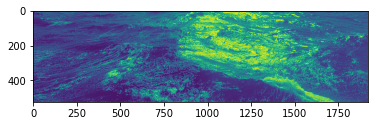

In [6]:
plt.imshow(img_roi)
cv2.imwrite('resnet_active4.png', img_roi)

True

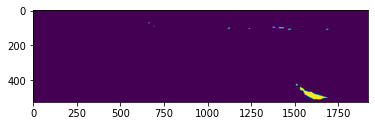

In [7]:
plt.imshow(output_vgg)
cv2.imwrite('resnet_active_mask4.png', output_BGR_vgg)

In [8]:
param_dir = 'E:/my-whitecaps/code/organized/model'
json_path = os.path.join(param_dir, 'params.json')
params = util.toolbox.Params(json_path)
params.cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = u_net.UNet(params).float()
checkpoint = torch.load("E:/my-whitecaps/code/organized/model/test/raw_test/best.pth.tar")
model.load_state_dict(checkpoint['state_dict'])

# intrinsic matrix of the camera
IntrinsicMatrix = np.array([[1.3533e3, 0, 1.1605e3], 
                            [0, 1.418e3, 529.8685], 
                            [0, 0, 1]])

# camera height
H = 7.0  
# 4.5 m for the lower one. 

# angle of camera when it is stable
incStab = 73 * np.pi / 180
rollStab = 0 * np.pi / 180
aziStab = 0  

img = cv2.imread("E:/GoPro_1Hz/2020_3_6_GoPro/image_left/GH080046.MP4/original_frame108.jpg")
roi_up, roi_bottom, line, rho, theta = get_ROI(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img_roi = img[roi_up: roi_bottom+1, 0:1920]
img_roi_tensor = torch.from_numpy(img_roi / 255).float()
img_roi_tensor = img_roi_tensor.unsqueeze(0)
img_roi_tensor = img_roi_tensor.unsqueeze(0)
model.to(device)
img_roi_tensor = img_roi_tensor.to(device)
with torch.no_grad():
    output = model(img_roi_tensor)
output = output.squeeze(0)
output = output.squeeze(0)

# assign all large than 0.8 as 1 and less as 0
output = output.cpu().numpy()


output[output >= 0.8] = 1
output[output < 0.8] = 0



output_BGR = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)
output_rectified = rectify(img,IntrinsicMatrix,H,incStab,rollStab,
                           aziStab,line,rho,theta,output)
img_roi_rec = rectify(img,IntrinsicMatrix,H,incStab,rollStab,
                      aziStab,line,rho,theta,img_roi)



C:\Users\yang.xin1022\AppData\Local\Temp\ipykernel_30040\989657926.py:130: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(-fu / (fv * np.tan(roll)))


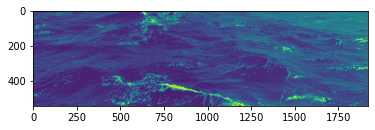

In [9]:
plt.imshow(img_roi)

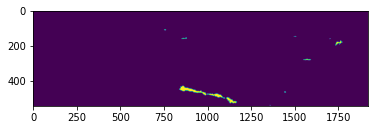

In [10]:
plt.imshow(output)